In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread
from skimage.transform import resize
import lime
import lime.lime_image
import os

In [12]:
# Load a sample image dataset (using a small subset of MNIST for simplicity)
# In a real scenario, you would load your specific image data

# Create dummy image data and labels for demonstration
# 10 images of size 28x28 (grayscale)
n_images = 10
img_size = 28
images = np.random.rand(n_images, img_size, img_size)
labels = np.random.randint(0, 2, n_images) # Binary classification

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (8, 28, 28)
Testing data shape: (2, 28, 28)


In [13]:
# Reshape images for the model (flattening for a simple classifier)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create and train a simple model (Random Forest Classifier)
# In a real scenario, you would likely use a deep learning model for images
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train_flat, y_train)

print("Model trained successfully.")

Model trained successfully.


  0%|          | 0/100 [00:00<?, ?it/s]

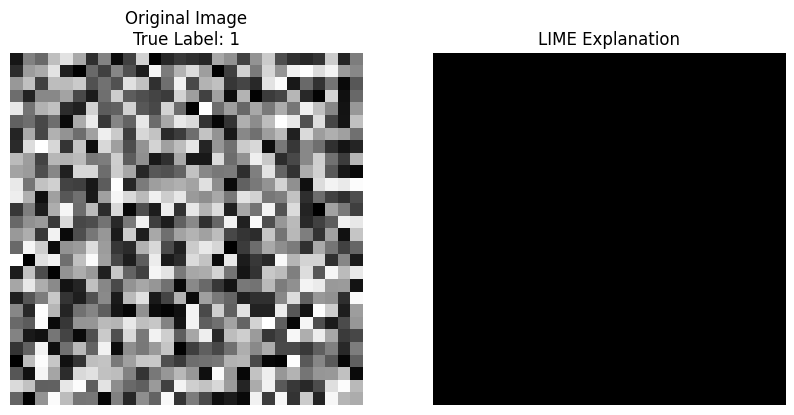

In [17]:
# Select an image to explain (e.g., the first image in the test set)
image_to_explain = X_test[0]
true_label = y_test[0]

# Reshape the image for LIME (LIME expects images in the format (height, width, channels))
# Since our dummy data is grayscale, we'll add a channel dimension
image_to_explain_lime = np.stack((image_to_explain,)*3, axis=-1) # Convert to RGB for LIME

# Initialize LIME explainer
explainer = lime.lime_image.LimeImageExplainer()

# Define a prediction function that flattens the image for the model
def predict_fn(images):
    # Flatten the images before passing them to the model, ignoring the channel dimension added for LIME
    images_flat = images.reshape(images.shape[0], -1)[:, :img_size * img_size] # Reshape to (batch_size, height * width)
    return model.predict_proba(images_flat)


# Generate explanation for the image
# hide_color is the color to use for hiding parts of the image
# num_samples is the number of perturbed images to generate for explanation
explanation = explainer.explain_instance(image_to_explain_lime,
                                         predict_fn, # Use the new prediction function
                                         top_labels=1, hide_color=0, num_samples=100)

# Get the image and mask for the most likely class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Display the original image and the LIME explanation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image_to_explain, cmap='gray')
ax1.set_title(f"Original Image\nTrue Label: {true_label}")
ax1.axis('off')

# Ensure the image is in the correct format for mark_boundaries (float between 0 and 1)
temp = temp.astype(float) / 255.0

ax2.imshow(mark_boundaries(temp, mask))
ax2.set_title("LIME Explanation")
ax2.axis('off')

plt.show()

# Task
Generate a LIME explanation for a CNN model trained on an image dataset.

## Load and prepare data

### Subtask:
Load a standard image dataset (like MNIST or CIFAR-10) and preprocess it for use with a neural network. This will likely involve normalization and reshaping.


**Reasoning**:
Load the MNIST dataset, normalize the pixel values, and reshape the images to include a channel dimension. Convert labels to categorical format.



In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the image data: normalize and reshape
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape images to include channel dimension (for grayscale, it's 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# Convert labels to categorical (one-hot encoding)
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train_cat.shape}")
print(f"Testing labels shape: {y_test_cat.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)
Training labels shape: (60000, 10)
Testing labels shape: (10000, 10)


## Build and train cnn model

### Subtask:
Define and train a simple Convolutional Neural Network (CNN) for image classification on the prepared data.


**Reasoning**:
Define and train a simple CNN model using the preprocessed MNIST data.



In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Create a Sequential model
model = Sequential()

# Add Conv2D and MaxPooling2D layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cat, epochs=5, batch_size=128, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.8746 - loss: 0.4635 - val_accuracy: 0.9789 - val_loss: 0.0677
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 114ms/step - accuracy: 0.9802 - loss: 0.0644 - val_accuracy: 0.9855 - val_loss: 0.0415
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9870 - val_loss: 0.0402
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 105ms/step - accuracy: 0.9900 - loss: 0.0318 - val_accuracy: 0.9889 - val_loss: 0.0331
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.9892 - val_loss: 0.0340
Test loss: 0.0340
Test accuracy: 0.9892
